# DATA PROCESS

This code create a new folder with two subfolders (image and mask) in which are saved the renamed raw datas (ex. TCGA-5P-A9K0-01Z-00-DX1_1.tif). Then this data are shown for a first check.


---


##Input
data_path (image, mask): Specify the path of downloaded images and mask

## Output
dataset_1: new folder

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Package imports
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from glob import glob
!pip install imagecodecs
import imagecodecs
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.colors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 89.4 MB/s eta 0:00:00


##First, I check that the order of the subfolders containing the images and masks is the same

In [ ]:
#estraggo il nome delle sotto cartelle della cartella IMAGE e MASK e le ordine in ordine alfabetico

In [ ]:
#define the input dataset
initial_cwd = os.getcwd() # Store the initial current working directory
image = os.path.join(initial_cwd, 'dataset') #Path to read raw image from
mask = os.path.join(initial_cwd, 'MoNuSAC_masks') #path to read raw mask from

# generate a list of all the elelements (file and path) in image' and 'mask'

IMAGES_SUBFOLDER = []
all_image_items = os.listdir(image)
for item in sorted(all_image_items):
    item_path = os.path.join(image, item)
    #check if is a folder
    if os.path.isdir(item_path):
        IMAGES_SUBFOLDER.append(item)


MASKS_SUBFOLDER = []
all_mask_items = os.listdir(mask)
for item in sorted(all_mask_items):
    item_path = os.path.join(mask, item)
    if os.path.isdir(item_path):
        MASKS_SUBFOLDER.append(item)

print(IMAGES_SUBFOLDER)
print(MASKS_SUBFOLDER)

['TCGA-55-1594-01Z-00-DX1', 'TCGA-5P-A9K0-01Z-00-DX1', 'TCGA-69-7760-01Z-00-DX1', 'TCGA-69-A59K-01Z-00-DX1', 'TCGA-73-4668-01Z-00-DX1', 'TCGA-78-7220-01Z-00-DX1', 'TCGA-86-7713-01Z-00-DX1', 'TCGA-86-8672-01Z-00-DX1', 'TCGA-A2-A0CV-01Z-00-DX1', 'TCGA-A2-A0ES-01Z-00-DX1', 'TCGA-B6-A0WZ-01Z-00-DX1', 'TCGA-B9-A44B-01Z-00-DX1', 'TCGA-B9-A8YI-01Z-00-DX1', 'TCGA-BH-A18T-01Z-00-DX1', 'TCGA-D8-A1X5-01Z-00-DX2', 'TCGA-DW-7841-01Z-00-DX1', 'TCGA-E2-A154-01Z-00-DX1', 'TCGA-E9-A22B-01Z-00-DX1', 'TCGA-E9-A22G-01Z-00-DX1', 'TCGA-EJ-5495-01Z-00-DX1', 'TCGA-EJ-5505-01Z-00-DX1', 'TCGA-EJ-5517-01Z-00-DX1', 'TCGA-EV-5903-01Z-00-DX1', 'TCGA-EW-A6SD-01Z-00-DX1', 'TCGA-F9-A97G-01Z-00-DX1', 'TCGA-G7-A8LD-01Z-00-DX1', 'TCGA-G9-6342-01Z-00-DX1', 'TCGA-G9-6499-01Z-00-DX1', 'TCGA-J4-A67Q-01Z-00-DX1', 'TCGA-J4-A67T-01Z-00-DX1', 'TCGA-KK-A59X-01Z-00-DX1', 'TCGA-KK-A6E0-01Z-00-DX1', 'TCGA-KK-A7AW-01Z-00-DX1', 'TCGA-L4-A4E5-01Z-00-DX1', 'TCGA-MH-A560-01Z-00-DX2', 'TCGA-MP-A4SY-01Z-00-DX1', 'TCGA-MP-A4T7-01Z-00-DX1', 

In [ ]:
i = sorted(next(os.walk(image))[1]) # list of image subfolders
m = sorted(next(os.walk(mask))[1]) #list of mask subfolders
print(f"Number of image subfolders: {len(i)}")
print(f"Number of mask subfolders: {len(m)}")


Number of image subfolders: 46
Number of mask subfolders: 46


In [ ]:
# Compare subfolders
if len(i) != len(m):
    print("Error: The number of subfolders in 'dataset' and 'MASK' directories do not match.")
else:
    all_match = True
    for k in range(len(i)):
        if i[k] == m[k]:
            print(f"Match: Image subfolder '{i[k]}' and Mask subfolder '{m[k]}' are identical.")
        else:
            print(f"Mismatch: Image subfolder '{i[k]}' and Mask subfolder '{m[k]} are different.")
            all_match = False
    if all_match:
        print("All image and mask subfolder names correspond.")
    else:
        print("Some image and mask subfolder names do NOT correspond.")


## CREATE THE TWO DATASETS: IMAGES AND MASK in a new folder called "dataframe_1"



In [ ]:
IMAGES_DEST =  os.path.join(initial_cwd, "dataframe_1", "images/")
MASKS_DEST = os.path.join(initial_cwd, "dataframe_1", "masks/")

print(IMAGES_DEST)
print(MASKS_DEST)

# Create folders
def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

create_directory(IMAGES_DEST)
create_directory(MASKS_DEST)

In [ ]:
iterator = 0

for ct in tqdm(range(len(IMAGES_SUBFOLDER[:]))):
    #Process bar
    print(IMAGES_SUBFOLDER[ct], MASKS_SUBFOLDER[ct])

    # Read all images in image sub folder
    imgs = sorted(glob(os.path.join(image, IMAGES_SUBFOLDER[ct], '*.tif')))

    # Iterate over the individual raw images
    for img_idx in range(len(imgs)):
        #read image
        img = skimage.io.imread(imgs[img_idx])
        if len(img.shape) > 2:
          img = img[:,:,:3]
        # Save it
        skimage.io.imsave(IMAGES_DEST+ f"{os.path.basename(imgs[img_idx])}", img)

    # Read the mask sub folders
    all_mask_subfolders = sorted(glob(os.path.join(mask, MASKS_SUBFOLDER[ct], '*')))

    # Iterate over the individual mask sub folders
    for j in range(len(all_mask_subfolders)):

        # Go to each sub folder
        # Read the 4 class folders
        class_sub_dir = sorted(glob(all_mask_subfolders[j]+ '/*'))

        # Make list for masks from each class fodlers
        final_masks = []

        # For each class folder get the mask
        for class_idx in range(len(class_sub_dir)):

            # get the mask in the subfolder
            mask_paths = sorted(glob(class_sub_dir[class_idx] + '/*.tif'))

            # If more than one mask present in folder(maybe not)
            # For each class folder: 1) read the mask 2) Convert to class label from the binary class label
            for k in range(len(mask_paths)):

                if class_idx == 0:
                    epithelial_mask = skimage.io.imread(mask_paths[k])
                    epithelial_mask = np.where(epithelial_mask==255.0, 1.0, epithelial_mask)
                    final_masks.append(epithelial_mask)
                if class_idx == 1:
                    lymphocyte_mask = skimage.io.imread(mask_paths[k])
                    lymphocyte_mask = np.where(lymphocyte_mask==255.0, 2.0, lymphocyte_mask)
                    final_masks.append(lymphocyte_mask)
                if class_idx == 2:
                    macrophage_mask = skimage.io.imread(mask_paths[k])
                    macrophage_mask = np.where(macrophage_mask==255.0, 4.0, macrophage_mask)
                    final_masks.append(macrophage_mask)
                if class_idx == 3:
                    neutrophil_mask = skimage.io.imread(mask_paths[k])
                    neutrophil_mask = np.where(neutrophil_mask==255.0, 3.0, neutrophil_mask)
                    final_masks.append(neutrophil_mask)

        # Overlay masks
        m = None
        if len(final_masks) == 1:
            # If only one mask, read it directly
            m = final_masks[0]

        elif len(final_masks) > 1:
            # For multiple masks, read maximum along the axis
            m = np.amax(np.array(final_masks), axis=0)
        else:
            # Handle case where no masks are found for a given image
            # Create an empty mask of a default size (e.g., from the last img read)
            if 'img' in locals() and img is not None and img.ndim >= 2: # Check if img was read and is valid
                m = np.zeros(img.shape[:2], dtype=np.float64)
            else:
                print(f"Warning: No masks found for {all_mask_subfolders[j]} and no valid image to get shape from. Skipping.")
                continue # Skip to the next iteration if no mask data and no img shape


        # Save it
        endmask = m.astype(np.uint8)
        skimage.io.imsave(MASKS_DEST + "{}.tif".format(f"{os.path.basename(all_mask_subfolders[j])}"), endmask)

        iterator+=1



## Organize dataset into a Pandas dataframe

In [ ]:
# Store all image and corresponding mask paths into a pandas dataframe

image_paths = []
mask_paths = []

# Get all image and masks files from the destination folder
# This assumes mask filenames are identical to image filenames in the destination folders
all_image_files = sorted(glob(os.path.join(IMAGES_DEST, '*.tif')))
all_mask_files = sorted(glob(os.path.join(MASKS_DEST, '*.tif')))

mask_file_map = {os.path.basename(p): p for p in all_mask_files}

for img_path in all_image_files:
    img_filename = os.path.basename(img_path)

    # Assuming the mask filename is identical to the image filename
    if img_filename in mask_file_map:
        msk_path = mask_file_map[img_filename]
        image_paths.append(img_path)
        mask_paths.append(msk_path)
    else:
        print(f"Warning: Mask not found for image: {img_path}")

# Create the pandas DataFrame
df = pd.DataFrame({"image_path": image_paths, "mask_path": mask_paths})

print(f"DataFrame created with {len(df)} entries.")
print(df.head())


## Visualize one random sample

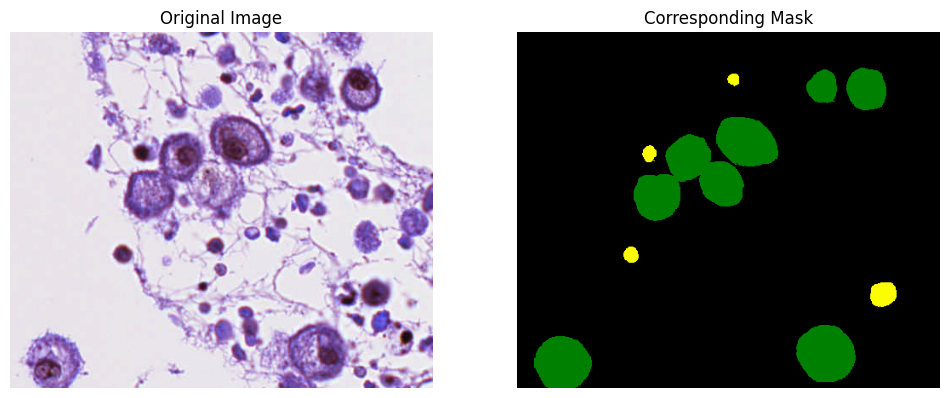

Index:  57
(419, 497, 3) (419, 497)


In [ ]:
# select a random index and display image and corresponding mask
random_idx = np.random.randint(0, len(df))
random_image_path = df.loc[random_idx, 'image_path']
random_mask_path = df.loc[random_idx, 'mask_path']

image = cv2.imread(random_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(random_mask_path, cv2.IMREAD_GRAYSCALE)

map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap=map_name)
plt.title('Corresponding Mask')
plt.axis('off')

plt.show()

print("Index: ", random_idx)
print(image.shape, mask.shape)

## Check on image's dimensions

In [ ]:
image_shape = []
w = []
h = []

for i in range(len(df)): # Iterate through the DataFrame's rows
  image_path = df.loc[i, 'image_path'] # Get the image path
  try:
    # Read the image to get its shape
    img = skimage.io.imread(image_path)
    shape = img.shape
    w.append(shape[1])
    h.append(shape[0])

    image_shape.append(shape)

  except Exception as e:
    print(f"Warning: Could not read image {image_path}: {e}")
    image_shape.append(None) # Append None if image can't be read

w = np.array(w)
h = np.array(h)

# Mean of hieght
np.mean(h), np.std(h)

# Mean of hieght
np.mean(w), np.std(w)

print(f"max heigh {np.max(h)} and min heigh {np.min(h)}.")
print(f"max width {np.max(w)} and min width {np.min(w)}.")



max heigh 1956 and min heigh 81.
max width 2162 and min width 74.
